In [1]:
import numpy as np

import scipy as sp
import matplotlib

from matplotlib import pyplot as plt


matplotlib.rcParams['axes.labelsize']= 15
matplotlib.rcParams['legend.fontsize']= 15
matplotlib.rcParams['axes.titlesize']= 15
#matplotlib.rcParams['font.sans-serif']= 'Helvetica'
matplotlib.rcParams['xtick.labelsize']= 12
matplotlib.rcParams['ytick.labelsize']= 12
matplotlib.rcParams['axes3d.grid']= False

#matplotlib.rcParams.keys()


# Notebook to play around with embedding theorems

## How to choose a *generic* measurement function?

Given a dynamical system with on a compact manifold $M$, dim$M=m$ (and charts $(U, x)$) with flow map $\phi : M \to M$,
we wonder how to choose an appropriate (generic) measurement function $y: M \to \mathbb{R}$ in order to apply Takens Theorem and make sure that the delay map 
$$ \begin{align*} \Phi_{(\phi, h)} : M &\to \mathbb{R}^{2m+1} \\  x &\mapsto (y(x), h(\phi(x)), \dots, h(\phi^{2m}(x)))^T\end{align*}
$$
is an embedding of $M$ into $\mathbb{R}^{2m+1}$.

In real-life experiments, we don't need to worry about this, since the *generic* property saves the day: the measurement function is "given" to us and we will never be on the complement of an open dense set, unless we are dealing with measurement functions that make use of some symmetry of the system. We will, though, work with equations and simulations from these. In that setting, we will define a measurement function by hand. This is why we worry to verify at least some of the necessary conditions to pick a generic function. 


For the flow map, we can state the assumptions that it has to verify in order to be generic: finite number of periodic points with period $<2m$ and no repeated eigenvalues of the Jacobian at periodic points with period $<2m$. Unfortunately, we don't have any "easy to verify" list of requirements (necessary and sufficient conditions) for the measurement function. We can get some inspiration, though, from the proof of Takens theorem. 


For example, we worry to check that, if we call $P_{2m}$ the set of periodic points with period $<2m$,
1. the measurement function $y$ takes distinct values at any $p \in P_{2m}$ (injectivity of the embedding) and
2. the gradient of the measurement function must not be orthogonal to any of the eigenvectors $e_1, \dots , e_d$ of the linearization at a point $p$ in $P_{2m}$ (immersivity of the embedding)

Let us first say why we want (1) and (2) as **necessary** conditions on fixed points. 

As to (1), consider that the delay map on a fixed point $x_0$ is $\Phi_{(\phi, h)}(x_0) = (y(x_0), \dots, h(x_0))$. It is then clear that, if we have two fixed points $x_{0,1} \neq x_{0,2}$, we need to require $y(x_{0,1}) \neq h(x_{0,2})$ for $\Phi_{(\phi,h)}$ not to fail at injectivity.

For (2), we are checking immersivity at fixed points $x_0$ and hence, given coordinates $(x^1, \dots, x^m)$ we need to look at $D_x \Phi_{(\phi, h)}|_{x_0}$ and check that it has full rank $m$. We have

$$  D_x \Phi_{(\phi,h)}|_{x_0} = \begin{pmatrix} \frac{\partial h }{\partial x ^1 }\Big|_{x_0} & \dots & \frac{\partial h }{\partial x ^m }\Big|_{x_0} \\  \frac{\partial h \circ \phi }{\partial x ^1 }\Big|_{x_0} & \dots & \frac{\partial h \circ \phi }{\partial x ^m }\Big|_{x_0} \\ 
\vdots & \dots & \vdots \\\frac{\partial h \circ (\phi)^{2m}}{\partial x ^1 }\Big|_{x_0} & \dots & \frac{\partial h \circ (\phi)^{2m} }{\partial x ^m }\Big|_{x_0} 
\end{pmatrix} $$

and, by the chain rule, using Einstein summation convention, we have 
$$\begin{align*} \frac{\partial h \circ \phi }{\partial x ^i }\Big|_{x_0} &= \frac{\partial h}{\partial x ^j }\Big|_{\phi(x_0)} \frac{\partial \phi^j }{\partial x ^i }\Big|_{x_0} \\ \frac{\partial h \circ \phi \circ \dots \circ \phi }{\partial x ^i }\Big|_{x_0} &= \frac{\partial h}{\partial x ^{j_1}}\Big|_{(\phi)^{2m} (x_0)} \frac{\partial \phi^{j_1} }{\partial x ^{j_2} }\Big|_{(\phi)^{2m-1} (x_0)} \dots \frac{\partial \phi^{j_{2m}} }{\partial x ^{i} }\Big|_{ x_0} \end{align*}
$$

Now, to make our life easier, we perform a linear change of coordinates so that we are in the eigenvector basis of the linearized flow map at the fixed point. We call the set of eigenvectors with eigenvalues $\lambda_1, \dots, \lambda_m$ $e_1, \dots e_m$, we collect them as column vectors in a matrix $V$, and denote the new coordinates $(\tilde{x}_1, \dots, \tilde{x}_m)$, so that $x = V^{-1} {\tilde{x}}$. 
The new flow map $\tilde{\phi}(\tilde{x}) =  V\phi(V^{-1} \tilde{x}) $ is now diagonal when linearized at $V^{-1} \tilde{x}_0 = x_0$ and
$$ \frac{\partial \tilde{\phi}^l }{\partial \tilde{x} ^{l}}\Big|_{V^{-1}\tilde{x}_0} = \lambda_l \delta_l^k$$
Hence $$ \begin{align*} \frac{\partial h \circ \tilde{\phi} }{\partial \tilde{x} ^{i}} \Big|_{V^{-1}\tilde{x}_0}  = \frac{\partial h}{\partial \tilde{x} ^{j}}\Big|_{V^{-1}\tilde{x}_0}\lambda_i \delta_i^j\Big|_{V^{-1}\tilde{x}_0} =\frac{\partial h}{\partial \tilde{x} ^{i}} \lambda_i  \end{align*}$$
and $$ \begin{align*} \frac{\partial h \circ \tilde{\phi} \circ \dots \circ \tilde{\phi} }{\partial \tilde{x} ^{i}} \Big|_{V^{-1}\tilde{x}_0}  = \frac{\partial h}{\partial \tilde{x} ^{j_1}}\Big|_{V^{-1}\tilde{x}_0}\lambda_{j_2} \delta_{j_2}^{j_1} \dots \lambda_{j_2} \delta_{j_i}^{j_{2m}}  = \frac{\partial h}{\partial \tilde{x} ^{i}}\Big|_{V^{-1}\tilde{x}_0} \lambda_i ^{2m}\end{align*}$$

Therefore, the matrix we need to check is 
$$ \begin{pmatrix}\frac{\partial h}{\partial \tilde{x} ^{1}}\Big|_{V^{-1}\tilde{x}_0}\begin{pmatrix} 1 \\ \lambda_1 \\ \dots \\ \lambda_1^{2m} \end{pmatrix} & \frac{\partial h}{\partial \tilde{x} ^{2}}\Big|_{V^{-1}\tilde{x}_0}\begin{pmatrix} 1 \\ \lambda_2 \\ \dots \\ \lambda_2^{2m} \end{pmatrix} & \vdots & \vdots & \frac{\partial h}{\partial \tilde{x} ^{m}}\Big|_{V^{-1}\tilde{x}_0}\begin{pmatrix} 1 \\ \lambda_m \\ \dots \\ \lambda_m^{2m} \end{pmatrix}\end{pmatrix} $$

Immediately, we see that, for all $i = 1, \dots, m$, we must have $\frac{\partial h}{\partial \tilde{x} ^{i}}\Big|_{V^{-1}\tilde{x}_0} \neq 0$

By looking at this conidtion more closely, we see that $$\frac{\partial h}{\partial \tilde{x} ^{i}} (V^{-1}\tilde{x} )\Big|_{x = x_0} = \frac{\partial h}{\partial {x} ^{i}}\Big|_{x = x_0} V^{-1} \neq 0$$

Remembering now that $V$ was the eigenvector matrix, that the inverse operation on matrices preserves invariant subspaces, and that $(\frac{\partial h}{\partial {x} ^{1}}, \dots, \frac{\partial h}{\partial {x} ^{m}})$ is the gradient $d h$ of $h$, we obtain the condition "the gradient of the measurement function must not be orthogonal to any of the eigenvectors $e_1, \dots , e_d$ of the linearization at a fixed point" 

**More rigorously**: the eigenvectors of the linearization at the fixed point must not be in the gradient's (which is a 1-form) kernel


This condition makes intuitive sense, since when we look at the linearization of the flow map we look at a local evolution of the flow. We don't want the local evolution of the measurement function to "miss" any direction of evolution. 


I believe that, as much as if we required the measurement functions to be injective the delay map would be injective, if we required the condition above to hold on each and every point of $M$, the delay map would be immersive. We don't want to require and/or check this, and this is the very reason why we have a Takens theorem and a proof that uses some tricks and the finite cover property etc etc. It might be worth it, though, to check conditions (1) and (2) on periodic points, to avoid easy-to-avoid mistakes


We might therefore want to verify these (**necessary but not sufficient**) conditions.

We can try this on the classic Lorenz equations

$$ \begin{cases} \dot{x} = \sigma(y-x) \\
\dot{y} = \rho x - y - xz \\
\dot{z} = -\beta z + xy \end{cases}


In [2]:
# Lorenz Equations

rho, sigma, beta =28,10, 8/3 
def lorenz_rhs(t,Y, is_forced = False, forcing= None, dt =1, rho=rho,sigma=sigma, beta=beta, ):
    dx = sigma*(Y[1]-Y[0])
    dy = rho*Y[0]-Y[1]- Y[0]*Y[2]
    dz = - beta*Y[2]+ Y[0]*Y[1]
    if is_forced:
        dz += forcing[int(t/dt)]
    return [dx, dy, dz]




In [3]:
t0 = 0
tf = 50
dt = 0.001
tspan = np.arange(t0, tf, dt)
p0 = 0.01* np.ones(3)
sol = sp.integrate.solve_ivp(lorenz_rhs,[tspan[0], tspan[-1]], p0, t_eval=tspan,).y

Given the Lorenz equation, we immediately see that there is a fixed point in zero. Therefore, we can start worrying about verifying (1) and (2) there.

First, we find the Jacobian

$$ J(x,y,z) = \begin{pmatrix} -\sigma & \sigma & 0 \\
\rho & -1 & -x \\
y & x & -\beta \end{pmatrix} $$



In [4]:
def Jac(X,rho=rho,sigma=sigma, beta=beta,):
    J = np.zeros((3,3))
    J[0] = np.array([-sigma, sigma, 0])
    J[1] = np.array([rho, -1, -X[0]])
    J[2] = np.array([X[1], X[0], -beta])
    #print(J)
    return J

In [5]:
evals, evecs =np.linalg.eig(Jac([0,0,0]))


evecs.T, np.linalg.inv(evecs).T


(array([[-0.61481679,  0.78866997,  0.        ],
        [-0.41650418, -0.9091338 ,  0.        ],
        [ 0.        ,  0.        ,  1.        ]]),
 array([[-1.02445108, -0.88870725,  0.        ],
        [ 0.46933483, -0.692802  ,  0.        ],
        [ 0.        , -0.        ,  1.        ]]))

We already see that, since in zero 
$$ J(0,0,0) = \begin{pmatrix} -\sigma & \sigma & 0 \\
\rho & -1 & 0 \\
0 & 0 & -\beta \end{pmatrix} $$

The eigenvector matrix will be of type

$$ V = \begin{pmatrix} a_{11} & a_{12} & 0 \\
a_{21} & a_{22} & 0 \\
0 & 0 & 1 \end{pmatrix} $$

and so will be its inverse $$ V^{-1} = \begin{pmatrix} a_{11}^{-1} & a_{12}^{-1} & 0 \\
a_{21}^{-1} & a_{22}^{-1} & 0 \\
0 & 0 & 1 \end{pmatrix} $$ 

We need to check that $$\langle \begin{pmatrix}\frac{\partial h} {\partial x} & \frac{\partial h} {\partial y} & \frac{\partial h} {\partial z}\end{pmatrix}\Big|_{(x,y,z) = (0,0,0)}, e_i \rangle \neq 0  \quad i = 1, 2, 3$$



In [10]:
# (Reasonably) gneric measurement function
def meas_g(X):
    return  X[1]+  X[2] 


# (Surely) non generic measurement function
def meas_ng(X):
    return X[1] + X[2]**2

We see that, for the measurement function $ h (x,y,z) = y+z$ we get the features better reproduced than for  $h (x,y,z) = y+z^2$
or $h(x,y,z) = z$ or $h(x,y,z) = x + y$.

This is expected. Take for example $h (x,y,z) = y+z^2$, the condition $$ \langle \begin{pmatrix}\frac{\partial h} {\partial x} & \frac{\partial h} {\partial y} & \frac{\partial h} {\partial z}\end{pmatrix} e_i \rangle = \langle \begin{pmatrix} 0 & 1 & 2z \end{pmatrix}\Big|_{(0,0,0)}, e_i \rangle = \langle \begin{pmatrix} 0 & 1 & 0 \end{pmatrix}, e_3 \rangle  \neq 0 $$ 
would fail 

In [7]:
%matplotlib widget
from takens_utils import compare_diagnostics, coordinates_embedding

[2.01681575e+03 3.47665495e+01 3.34548271e-01 4.15422332e-03
 4.79822164e-04 2.12479574e-04 1.05116132e-04]


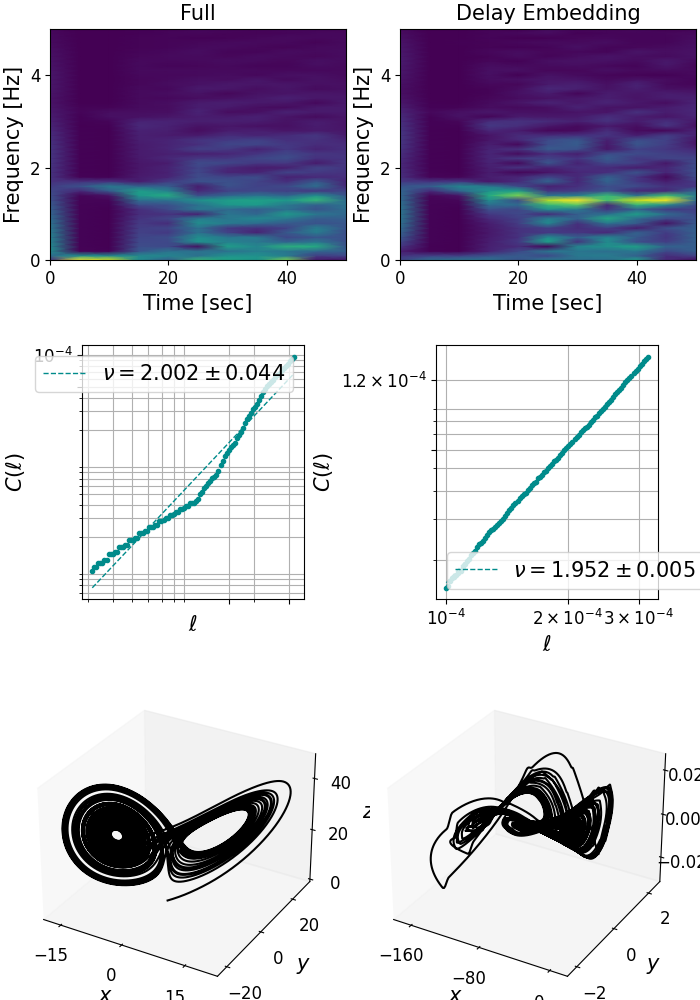

In [8]:
imdim = 3
over_embedding = 0
fs = (1/dt)
tplot = 100

phi_g = np.expand_dims(meas_g(sol), axis =0)

t_y, y_g, opts_embedding = coordinates_embedding([tspan], [phi_g] ,
                                              imdim = imdim, over_embedding = over_embedding)


U, S, Vtt = np.linalg.svd((y_g[0][:,:][:,::10].T-np.mean(y_g[0][:,:][:,::10], axis = 1)).T)
print(S[:10])
d = 3
E = U[:,0:d]
y_gpc = np.dot(E.T, y_g[0])
compare_diagnostics(sol[:,tplot:], y_g[0][:,tplot:],y_gpc[:, tplot:], fs,)



[2.80997561e+03 3.33884487e+01 3.41896531e-01 3.31312567e-03
 3.24186217e-04 1.48066437e-04 6.22698459e-05]


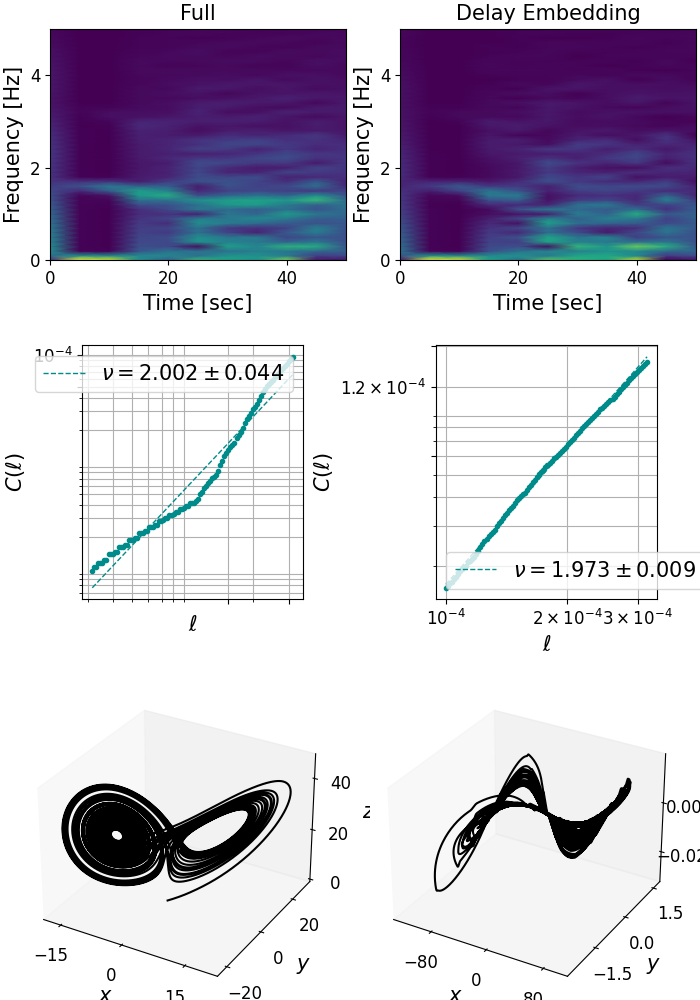

In [9]:

phi_ng = np.expand_dims(meas_ng(sol), axis =0)

t_y, y_ng, opts_embedding = coordinates_embedding([tspan], [phi_ng] ,
                                              imdim = imdim, over_embedding = over_embedding)
U, S, Vtt = np.linalg.svd((y_ng[0][:,:][:,::10].T-np.mean(y_ng[0][:,:][:,::10], axis = 1)).T)
print(S[:10])
d = 3
E = U[:,0:d]
y_ngpc = np.dot(E.T, y_ng[0])
compare_diagnostics(sol[:,tplot:], y_ng[0][:,tplot:], y_ngpc[:, tplot:], fs,)

We can now look at what happens for the other two fixed points in $(x,y,z )=(\pm \sqrt{\beta(\rho-1)}, \pm \sqrt{\beta(\rho-1)}, \rho-1)$



In [10]:
def compute_tSpace(evals,evecs):
    Es = np.copy(np.real(evecs))


    Ces = Es[:,np.nonzero(np.imag(evals))[0] ]
    Rsev = np.real(evecs[:,np.nonzero(np.imag(evals))[0] ])
    Csev = np.imag(evecs[:,np.nonzero(np.imag(evals))[0] ])
    Ces[:,::2] = Rsev[:,::2]
    Ces[:,1::2] = Csev[:,1::2]

    Es[:,np.nonzero(np.imag(evals))[0] ]=Ces

    return Es[:,np.flip(np.argsort(evals))]


In [11]:
fp1 = [np.sqrt(beta*(rho-1)), np.sqrt(beta*(rho-1)), rho-1]
fp2 = [-np.sqrt(beta*(rho-1)),- np.sqrt(beta*(rho-1)), rho-1]
evals1, evecs1 = np.linalg.eig(Jac(fp1))
evals2, evecs2 = np.linalg.eig(Jac(fp2))

evecs1 = compute_tSpace(evals1, evecs1)
evecs2 = compute_tSpace(evals2, evecs2)
np.linalg.inv(evecs1).T, np.linalg.inv(evecs2).T

(array([[-0.0890367 , -3.62947557, -1.08698059],
        [ 0.03536289, -2.66578008,  0.43171827],
        [ 1.22276756,  2.58100118,  0.18415931]]),
 array([[-0.0890367 , -3.62947557, -1.08698059],
        [ 0.03536289, -2.66578008,  0.43171827],
        [-1.22276756, -2.58100118, -0.18415931]]))

Ok, we don't need to worry about those points unless we're very unlucky

Anyway, these conditions are only necessary but not sufficient. We need to look at the proof more carefully but I am afraid one would need to check, at every point, if 
$$ \begin{bmatrix} \frac{\partial \varphi}{\partial x^1}(p) & \frac{\partial \varphi \circ f }{\partial x^1}(p) & \dots & \frac{\partial \varphi \circ f^(d-1)}{\partial x^1}(p) \\ \vdots & \vdots & \vdots & \vdots \\
 \frac{\partial \varphi}{\partial x^m}(p) & \frac{\partial \varphi \circ f }{\partial x^m}(p) & \dots & \frac{\partial \varphi \circ f^(d-1)}{\partial x^m}(p) 
\end{bmatrix} $$ 

is full rank at every point.

I guess that, since we apply the flow map afterwards, we should be safe. May be worth it to check what happens at zero, though, as a general rule.
